In [409]:
import math
import pandas as pd
import numpy as np

import os.path
import pickle

import quandl
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

from sklearn import preprocessing,svm
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression

In [410]:
df = quandl.get("WIKI/GOOGL")

In [411]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [412]:
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume']]

In [413]:
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0


In [414]:
df ['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df ['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]

In [415]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0
2004-08-20,54.322689,0.710922,7.227007,22834300.0
2004-08-23,54.869377,3.729433,-1.227880,18256100.0
2004-08-24,52.597363,6.417469,-5.726357,15247300.0
2004-08-25,53.164113,1.886792,1.183658,9188600.0


In [416]:
forecast_col = 'Adj. Close'

In [417]:
# it can be treated as an outlier if there is any missing value
df.fillna(-999999, inplace=True)

In [418]:
# forecast for next 10 days .. 
forecast_out = int(math.ceil(0.1 * len(df)))
forecast_out

343

In [419]:
df['label'] = df[forecast_col].shift(-forecast_out)

In [420]:
X = np.array(df.drop(['label'],axis=1))
X = preprocessing.scale(X)

X = X[:-forecast_out]
X_lately = X[-forecast_out:]

df.dropna(inplace=True)
y = np.array(df['label'])

In [421]:
print(X.shape)
print(y.shape)

(3081, 4)
(3081,)


In [422]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [423]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2464, 4)
(2464,)
(617, 4)
(617,)


In [424]:
path = 'saved_models/linearRegressionForecast.pickle'
is_file_exist = os.path.exists(path)
if not is_file_exist:
    print('creating pickle file...', end='')
    # n_jobs is the number of threads (jobs) for this computation. -1 means all the processors
    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)
    
    # save the model 
    with open(path,'wb') as f:
        pickle.dump(clf, f)
    print('done.') 

In [425]:
# open the model if file exists
if is_file_exist:
    pickle_in = open(path, 'rb')
    clf = pickle.load(pickle_in)

In [426]:
accuracy = clf.score(X_test, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.7469378841678012


In [427]:
forecaset_set = clf.predict(X_lately)

In [428]:
print(forecaset_set[0:20], '\n Forecast of {} days:'.format(forecast_out))

[565.46271885 556.37558769 559.65086328 571.11460711 587.20631627
 598.57776351 599.12134028 616.00515476 712.05006927 708.04594915
 710.51732521 709.25268625 688.4073522  667.84673186 673.48520419
 675.87467884 677.91023039 680.82680511 673.32976457 681.32616947] 
 Forecast of 343 days:


In [429]:
df['Forecast'] = np.nan

In [430]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecaset_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix +=one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

In [431]:
df.tail()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label,Forecast
Date,,,,,,
2017-10-14 19:00:00,NaN,NaN,NaN,NaN,NaN,798.292228
2017-10-15 19:00:00,NaN,NaN,NaN,NaN,NaN,819.878932
2017-10-16 19:00:00,NaN,NaN,NaN,NaN,NaN,829.920118
2017-10-17 19:00:00,NaN,NaN,NaN,NaN,NaN,822.752973
2017-10-18 19:00:00,NaN,NaN,NaN,NaN,NaN,793.789485


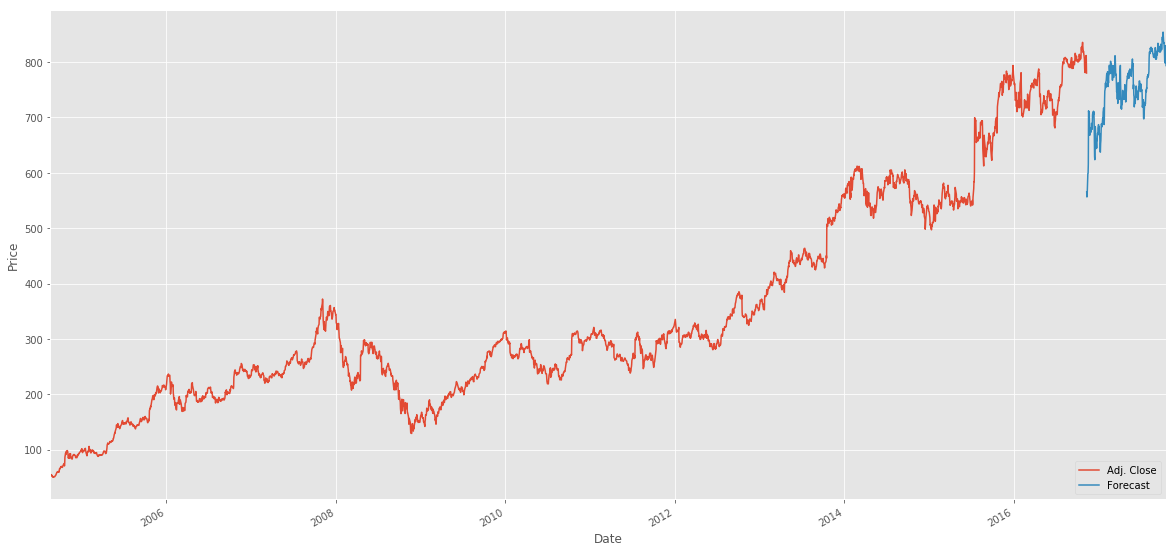

In [432]:
plt.figure(figsize=(20,10))
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show();